In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
N_EPOCHS = 1000

df = pd.read_csv('../benchmarks/results_cpu_all_omp_static.csv')
df['n_organisms'] = df['grid_width'] * df['grid_height']
df['time_per_epoch'] = df['time'] / N_EPOCHS
df

,n_threads,grid_width,grid_height,mutation_rate,genome_size,time,n_organisms,time_per_epoch
0,8,32,32,0.000100,500,134295,1024,134.295
1,8,32,32,0.000010,500,103040,1024,103.040
2,8,32,32,0.000001,500,102114,1024,102.114
3,8,128,128,0.000100,500,1463354,16384,1463.354
4,8,128,128,0.000010,500,853253,16384,853.253
...,...,...,...,...,...,...,...,...
1315,6,32,32,0.000001,50000,855800,1024,855.800
1316,6,128,128,0.000100,50000,289391612,16384,289391.612
1317,6,128,128,0.000010,50000,68006495,16384,68006.495
1318,6,128,128,0.000001,50000,12384768,16384,12384.768


## Computing speedup

There definitely is a less stupid way of doing this

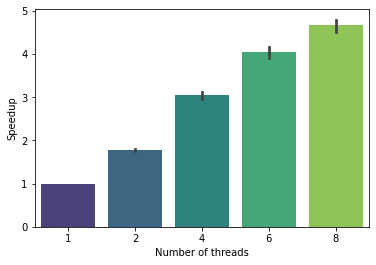

In [3]:
for n_organisms in df['n_organisms'].unique():
    for mutation_rate in df['mutation_rate'].unique():
        for genome_size in df['genome_size'].unique():
            baseline = df[(df['n_threads'] == 1) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time'].mean()
            for n_threads in df['n_threads'].unique():
                df.loc[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size), 'speedup'] = baseline / df[(df['n_threads'] == n_threads) & (df['n_organisms'] == n_organisms) & (df['mutation_rate'] == mutation_rate) & (df['genome_size'] == genome_size)]['time']


ax = sns.barplot(data=df, x='n_threads', y='speedup', palette="viridis")
ax.set_xlabel("Number of threads")
ax.set_ylabel("Speedup")
ax.get_figure().savefig('img/speedup.pdf')

## Graphing mean time per epoch

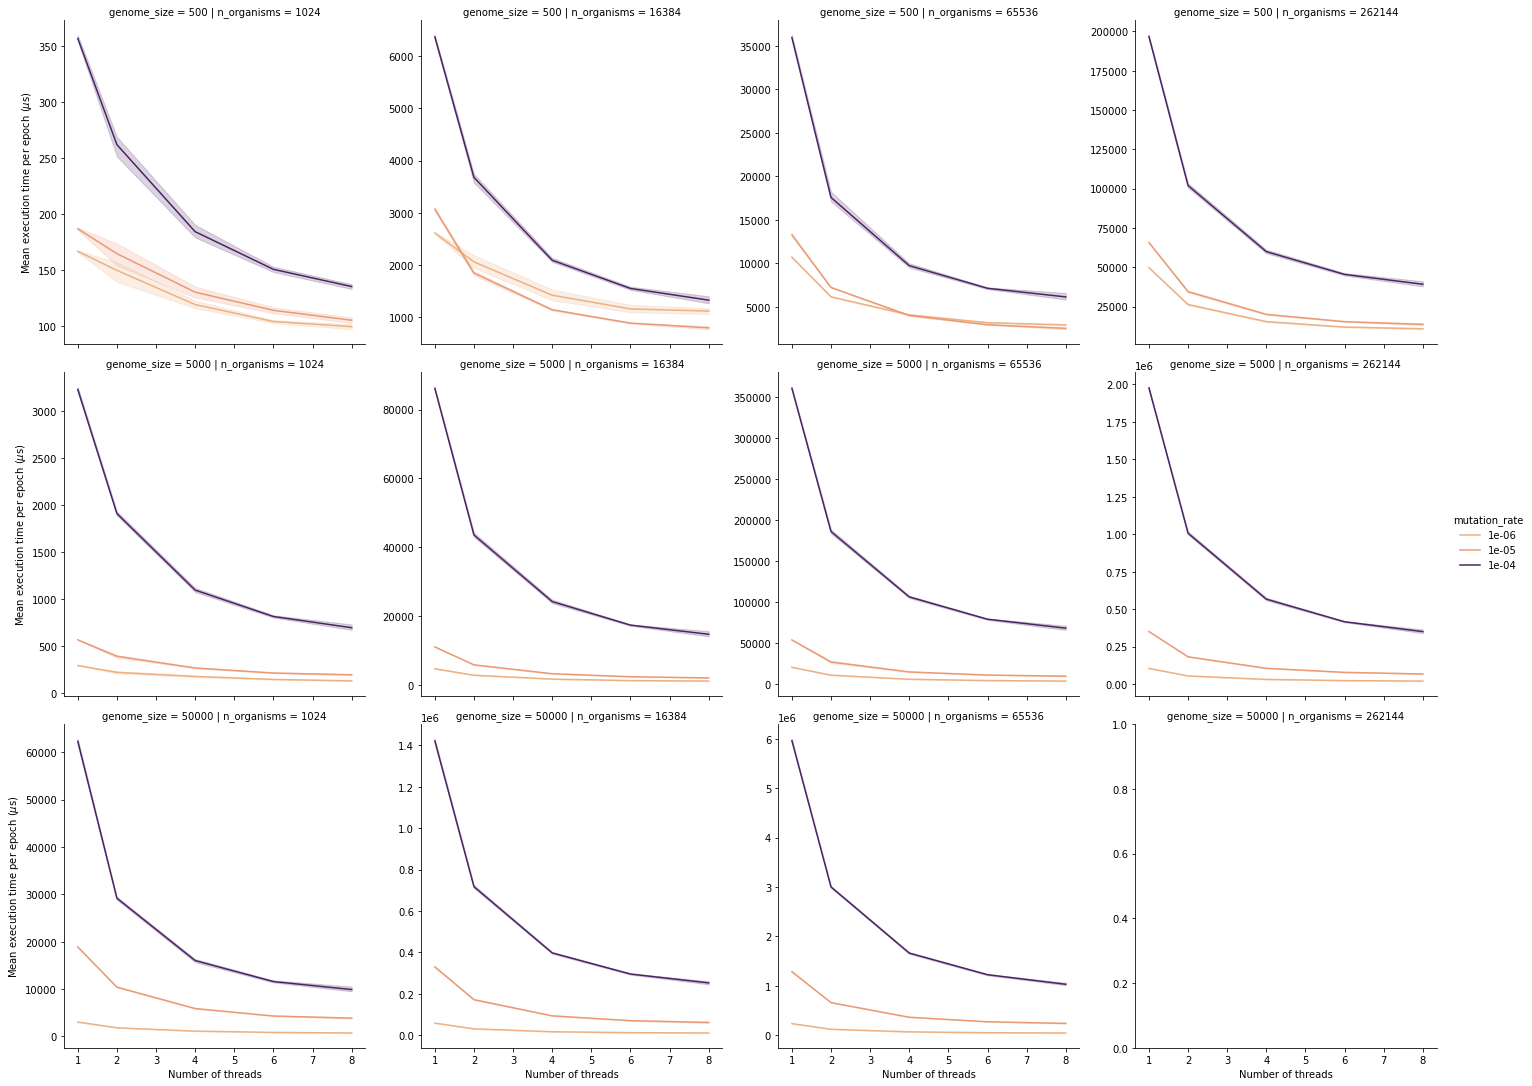

In [4]:
df_no_swp = df[(df['n_organisms'] != 512*512) | (df['genome_size'] != 50000)]
fig = sns.relplot(data=df_no_swp, x="n_threads", y="time_per_epoch", hue="mutation_rate", col="n_organisms", kind="line", row="genome_size", legend="full", facet_kws={'sharey': False}, palette='flare')
fig.set_xlabels("Number of threads")
fig.set_ylabels("Mean execution time per epoch ($\mu$s)")

# fix mix of scientific and decimal notation 
for legend in fig._legend.texts:
    legend.set_text( f'{float(legend.get_text()):.0e}')

plt.show(fig)
fig.savefig('img/benchmark_omp_static.pdf')

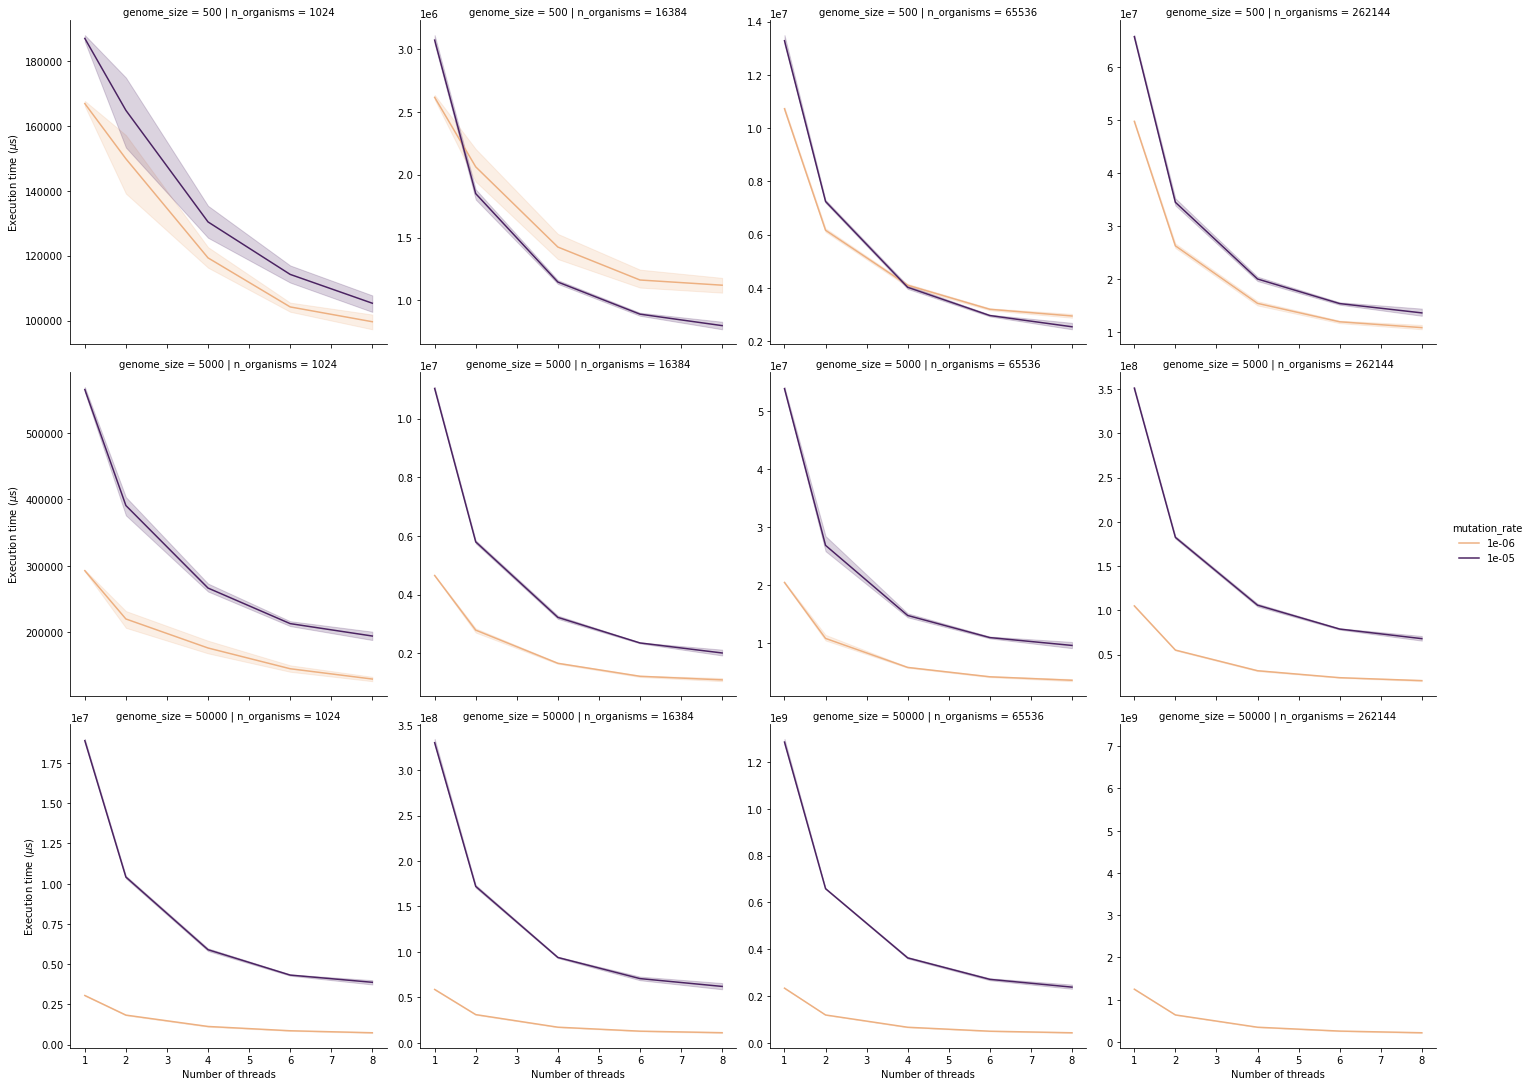

In [5]:
df_small = df[df["mutation_rate"] != 1e-4]
fig = sns.relplot(data=df_small, x="n_threads", y="time", hue="mutation_rate", col="n_organisms", kind="line", row="genome_size", legend="full", facet_kws={'sharey': False}, palette='flare')
fig.set_xlabels("Number of threads")
fig.set_ylabels("Execution time ($\mu$s)")

# fix mix of scientific and decimal notation 
for legend in fig._legend.texts:
    legend.set_text( f'{float(legend.get_text()):.0e}')

plt.show(fig)
fig.savefig('img/benchmark_omp_static_small.pdf')